# Conditional GAN

<center>

| Teammember | Name               | Kürzel             |
|------------|--------------------|--------------------|
| 1.         | Nicolas Reinhart   | nr063              |
| 2.         | Manuel Heim        | mh375              |
| 3.         | Silas Blumenstock  | sb309              |
| 4.         | Michael Partes     | mp176              | 

<center>

In this notebook, we have implemented a [Conditional GAN (CGAN)](https://arxiv.org/pdf/1411.1784.pdf). A CGAN is similar to a normal GAN and also has a discriminator and a generator. The conditional aspect of CGAN means that the generator is given additional input, which is used to condition the generated data. This additional input can be in the form of class labels, images, or any other form of data that is relevant to the generation task. That means that during the training, we pass images to the network with their actual labels for it to learn the difference between them. That way, we gain the ability to ask our model to generate images of specific labels.

In [2]:
from IPython.display import Image
# Image(filename='notebook_imgs/CGAN_Overview.png')

We also trained our CGAN on the MNIST dataset and give the class label as additional condition. This makes it possible to generate digits of a certain class, which is not the case in normal GANs, since they are generated only by chance. In this notebook we implemented such a CGAN.

## Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
# from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline 

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
a = tf.constant(2.5)
b = tf.constant(4.0)
print(a * b)

tf.Tensor(10.0, shape=(), dtype=float32)


## Hyperparameters

In [6]:
NUM_CHANNELS = 1        
NUM_CLASSES = 10        
IMAGE_SIZE = 28         # Image Size
LATENT_DIM = 128        # Noise Dimension
LEARNING_RATE = 0.0002
BATCH_SIZE = 128
EPOCHS = 10

## Import of the data

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = np.concatenate([X_train, X_test])
y_train = np.concatenate([y_train, y_test])
X_train.shape, y_train.shape

((70000, 28, 28), (70000,))

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_train = (X_train - 127.5) / 127.5
print("Min:", X_train.min(), "Max:", X_train.max())

Min: -1.0 Max: 1.0


Here we are plotting the first 10 Numbers of the dataset and the corresponding label:

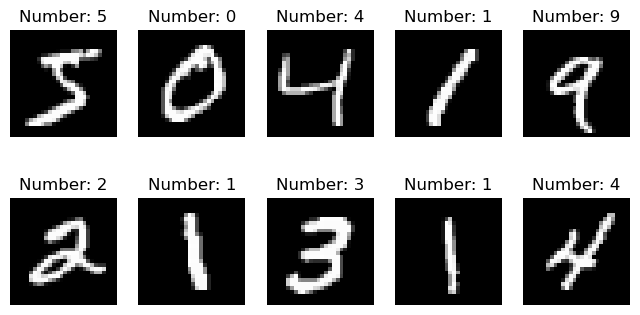

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(8,4), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].imshow(X_train[n], cmap='gray')
        axs[i,j].set(title=f"Number: {y_train[n]}")
        axs[i,j].axis('off')
        n=n+1
plt.show() 

## Generator

Here we build our Generator model. As Input it gets the label and the normal Noise Dimension.

In [10]:
def build_generator(IN_SHAPE = (7, 7, 1)):
    
    # Label Input:
    label_in = Input(shape=(1,), name='Label-Input') # Shape=(1,) because of class label
    lbls = Embedding(NUM_CLASSES, 50, name='Label-Embedding-Layer')(label_in) # Embed label to vector
    
    n_nodes = IN_SHAPE[0] * IN_SHAPE[1] 
    lbls = Dense(n_nodes, name='Label-Dense-Layer')(lbls)
    lbls = Reshape((IN_SHAPE[0], IN_SHAPE[1], 1), name='Label-Reshape-Layer')(lbls)

    # Normal Generator Input:
    latent_in = Input(shape=(LATENT_DIM ,), name='Latent-Input-Layer')
    
    # Image Foundation 
    n_nodes = IN_SHAPE[0] * IN_SHAPE[1] * LATENT_DIM
    gen = Dense(n_nodes, name='Foundation-Layer')(latent_in)
    gen = ReLU(name='Foundation-Layer-Activation')(gen)
    gen = Reshape((IN_SHAPE[0], IN_SHAPE[1], 128), name='Foundation-Layer-Reshape')(gen)
    concat = Concatenate(name='Combine-Layer')([gen, lbls])

    gen = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same')(concat)
    gen = ReLU()(gen)
    
    gen = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Output-Layer')(gen)
    
    model = Model([latent_in, label_in], output_layer, name='Generator')
    return model

generator = build_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent-Input-Layer (InputLayer  [(None, 128)]       0           []                               
 )                                                                                                
                                                                                                  
 Label-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Foundation-Layer (Dense)       (None, 6272)         809088      ['Latent-Input-Layer[0][0]']     
                                                                                                  
 Label-Embedding-Layer (Embeddi  (None, 1, 50)       500         ['Label-Input[0][0]']    

### Example Image

1/1 [==============================] - 5s 5s/step


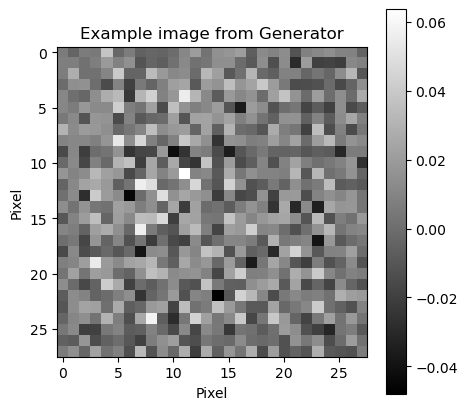

In [11]:
latent_input = np.random.randn(LATENT_DIM)
latent_input = latent_input.reshape(1, LATENT_DIM)

pred = generator.predict([latent_input, np.array([1])])
plt.figure(figsize=(5, 5))
plt.title("Example image from Generator")
plt.imshow(pred[0], cmap='gray')
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.colorbar()
plt.show()

## Discriminator

In [21]:
def build_discriminator(IN_SHAPE = (28, 28, 1)):
    
    # Label Inputs (same as in Generator)
    label_in = Input(shape=(1,), name='Label-Input-Layer') # Input Layer
    lbls = Embedding(NUM_CLASSES, 50, name='Label-Embedding-Layer')(label_in) # Embed label to vector
    
    n_nodes = IN_SHAPE[0] * IN_SHAPE[1] 
    lbls = Dense(n_nodes, name='Label-Dense-Layer')(lbls)
    lbls = Reshape((IN_SHAPE[0], IN_SHAPE[1], 1), name='Label-Reshape-Layer')(lbls) # New shape

    # Normal Discriminator Input
    image_in = Input(shape=IN_SHAPE, name='Image-Input-Layer')
    concat = Concatenate(name='Combine-Layer')([image_in, lbls])
    

    dis = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same')(concat)
    dis = LeakyReLU(alpha=0.2)(dis)
    
    dis = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same')(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(dis)
    
    dis = Flatten()(dis)
    dis = Dropout(0.2)(dis)
   
    output_layer = Dense(1, activation='sigmoid', name='Output-Layer')(dis)
    
    model = Model([image_in, label_in], output_layer, name='Discriminator')
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5), metrics=['accuracy'])
    return model

discriminator = build_discriminator()
discriminator.summary()

/Users/Nick/Documents/HDM/MASTER/__thesis/code/_project/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Label-Input-Layer   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Embedding-La… │ (None, 1, 50)     │        500 │ Label-Input-Laye… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Dense-Layer   │ (None, 1, 784)    │     39,984 │ Label-Embedding-… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image-Input-Layer   │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Reshape-Layer │ (None, 28, 28, 1) │          0 │ Label-Dense-Laye… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Combine-Layer       │ (None, 28, 28, 2) │          0 │ Image-Input-Laye… │
│ (Concatenate)       │                   │            │ Label-Reshape-La… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      1,216 │ Combine-Layer[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 7, 7, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 3, 128) │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1152)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Layer        │ (None, 1)         │      1,153 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,709 (455.89 KB)

 Trainable params: 116,709 (455.89 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
discriminator.predict([pred, np.array([1])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[0.50084496]], dtype=float32)

## Build CGAN

In [23]:
def def_cgan(generator, discriminator):
    
    # We dont want to train the discriminator at first (Like in GAN of ML-Notebook)
    discriminator.trainable = False
    
    gen_latent, gen_label = generator.input
    gen_output = generator.output
    gan_output = discriminator([gen_output, gen_label])
    
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5))
    return model

cgan = def_cgan(generator, discriminator)
cgan.summary()

Model: "cDCGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Latent-Input-Layer  │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Foundation-Layer    │ (None, 6272)      │    809,088 │ Latent-Input-Lay… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Embedding-La… │ (None, 1, 50)     │        500 │ Label-Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Foundation-Layer-A… │ (None, 6272)      │          0 │ Foundation-Layer… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Dense-Layer   │ (None, 1, 49)     │      2,499 │ Label-Embedding-… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Foundation-Layer-R… │ (None, 7, 7, 128) │          0 │ Foundation-Layer… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label-Reshape-Layer │ (None, 7, 7, 1)   │          0 │ Label-Dense-Laye… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Combine-Layer       │ (None, 7, 7, 129) │          0 │ Foundation-Layer… │
│ (Concatenate)       │                   │            │ Label-Reshape-La… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    264,320 │ Combine-Layer[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    262,272 │ re_lu[0][0]       │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Layer        │ (None, 28, 28, 1) │      6,273 │ re_lu_1[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │    116,709 │ Output-Layer[0][… │
│ (Functional)        │                   │            │ Label-Input[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,461,661 (5.58 MB)

 Trainable params: 1,344,952 (5.13 MB)

 Non-trainable params: 116,709 (455.89 KB)

## Training

The Training is nearly the same with a normal GAN, but we need to integrate the label into the Input.

In [13]:
def real_samples(data, labels, n_size):
    indx = np.random.randint(0, data.shape[0], n_size)
    X, digit_labels = data[indx], labels[indx]
    y = np.ones((n_size, 1))
    return [X, digit_labels], y

def latent_vector(n_size):
    latent_input = np.random.randn(LATENT_DIM * n_size)
    latent_input = latent_input.reshape(n_size, LATENT_DIM)
    digit_labels = np.random.randint(0, NUM_CLASSES, n_size)
    return [latent_input, digit_labels] 

def fake_samples(n_size):
    latent_output, digit_labels = latent_vector(n_size)
    X = generator.predict([latent_output, digit_labels])
    y = np.zeros((n_size, 1))
    return [X, digit_labels], y

In [14]:
def plot_images(rows, cols, n_size):
    x_fake, y_fake = fake_samples(n_size)
    X_tst = (x_fake[0] + 1) / 2.0

    plt.figure(figsize=(cols, rows), constrained_layout = True)
    for i in range(rows*cols):
        plt.subplot(rows, cols, 1 + i)
        plt.imshow(X_tst[i], cmap = 'gray')
        plt.title(f"Label: {x_fake[1][i]}", fontsize=10)
        plt.axis('off')
    plt.show()

In [15]:
fake_samples(10)

1/1 [==============================] - 1s 556ms/step


([array([[[[ 6.56140503e-03],
           [-9.03386332e-04],
           [-4.83048661e-03],
           ...,
           [-1.00593106e-03],
           [ 2.08753743e-03],
           [-8.75451893e-04]],
  
          [[-4.98283422e-03],
           [ 2.00995076e-02],
           [-2.20293831e-03],
           ...,
           [ 6.92496216e-03],
           [ 2.23647915e-02],
           [ 5.31818205e-03]],
  
          [[ 3.10456310e-03],
           [-4.63538244e-03],
           [-2.96672946e-03],
           ...,
           [-9.35531501e-03],
           [ 8.10128916e-03],
           [-8.82093422e-03]],
  
          ...,
  
          [[ 4.69751284e-03],
           [ 4.09346167e-03],
           [ 4.88389889e-03],
           ...,
           [-7.61018973e-03],
           [ 3.20295425e-04],
           [ 3.00778844e-03]],
  
          [[ 7.69357663e-03],
           [ 2.46941042e-03],
           [ 1.75515408e-04],
           ...,
           [-1.41715240e-02],
           [ 1.04316073e-02],
           [-2.1

In [18]:

[latent_input, cat_labels] = latent_vector(BATCH_SIZE)
latent_input.shape

(128, 128)

In [20]:
cat_labels

array([8, 9, 8, 1, 0, 5, 3, 6, 4, 3, 2, 1, 4, 5, 2, 9, 5, 0, 8, 2, 7, 5,
       1, 5, 5, 8, 7, 2, 0, 6, 2, 1, 8, 1, 1, 7, 2, 3, 9, 3, 3, 0, 1, 9,
       5, 7, 1, 6, 3, 7, 2, 3, 0, 8, 0, 8, 5, 8, 9, 8, 0, 4, 4, 7, 0, 0,
       3, 7, 8, 2, 4, 0, 3, 4, 9, 2, 1, 5, 2, 6, 8, 8, 6, 8, 7, 0, 6, 6,
       1, 3, 0, 1, 4, 6, 8, 1, 4, 9, 4, 5, 5, 0, 9, 0, 9, 9, 9, 9, 9, 5,
       7, 9, 9, 2, 2, 9, 9, 8, 8, 5, 7, 3, 5, 6, 7, 6, 1, 5])

In [34]:
def train(data, labels):
    BATCH_COUNT = data.shape[0] // BATCH_SIZE
    HALF_BATCH = BATCH_SIZE // 2
    
    for i in range(EPOCHS):
        for j in range(BATCH_COUNT):
    
            # Discriminator training
            [x_real, cat_labels_real], y_real = real_samples(data, labels, HALF_BATCH)
            discriminator_loss1, _ = discriminator.train_on_batch([x_real, cat_labels_real], y_real)
            
            [x_fake, cat_labels_fake], y_fake = fake_samples(HALF_BATCH)
            discriminator_loss2, _ = discriminator.train_on_batch([x_fake, cat_labels_fake], y_fake)

            # Generator training
            [latent_input, cat_labels] = latent_vector(BATCH_SIZE)
            y_gan = np.ones((BATCH_SIZE, 1))
            generator_loss = cgan.train_on_batch([latent_input, cat_labels], y_gan)
        
            if j % 250 == 0:
                print(f'Epoch: {i+1}/{EPOCHS}, Batch: {j+1}/{BATCH_COUNT}, D_Loss_Real={discriminator_loss1}, D_Loss_Fake={discriminator_loss2}, Gen_Loss={generator_loss}')
                plot_images(1, 5, LATENT_DIM)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch: 1/10, Batch: 1/546, D_Loss_Real=0.662092924118042, D_Loss_Fake=0.6667603254318237, Gen_Loss=[array(0.6667603, dtype=float32), array(0.6667603, dtype=float32), array(0.4546875, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


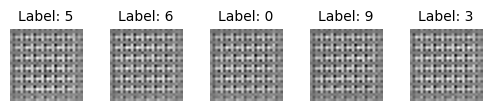

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━

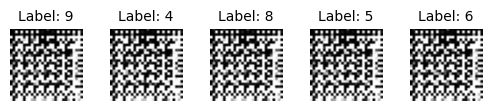

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━

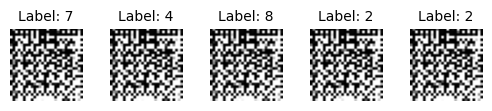

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━

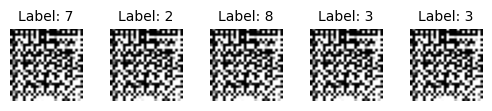

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━

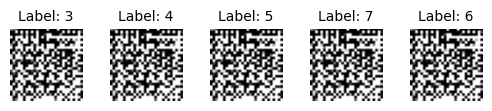

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━

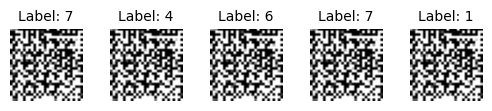

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━

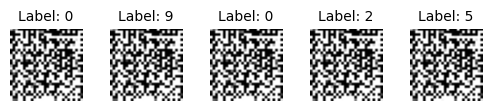

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━

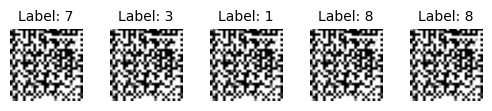

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━

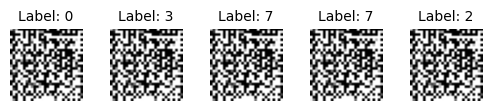

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

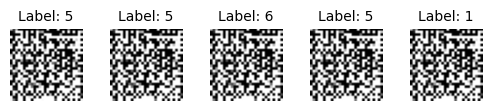

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

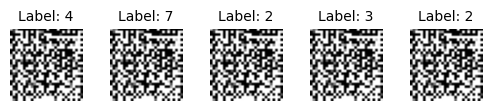

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━

In [35]:
train(X_train, y_train)

In [17]:
generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5))
generator.save('./models/cgan_generator.h5')

### Create example Images

In [24]:
def create_images() -> None: 

    latent_points, _ = latent_vector(100)
    labels = np.asarray([x for _ in range(10) for x in range(10)])
    gen_imgs  = generator.predict([latent_points, labels])

    fig, axs = plt.subplots(10, 10, figsize=(12, 12), constrained_layout = True)
    k=0
    for i in range(0,10):
        for j in range(0,10):
            axs[i,j].matshow(gen_imgs[k], cmap='gray')
            axs[0,j].set(title=f"Label: {labels[k]}")
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

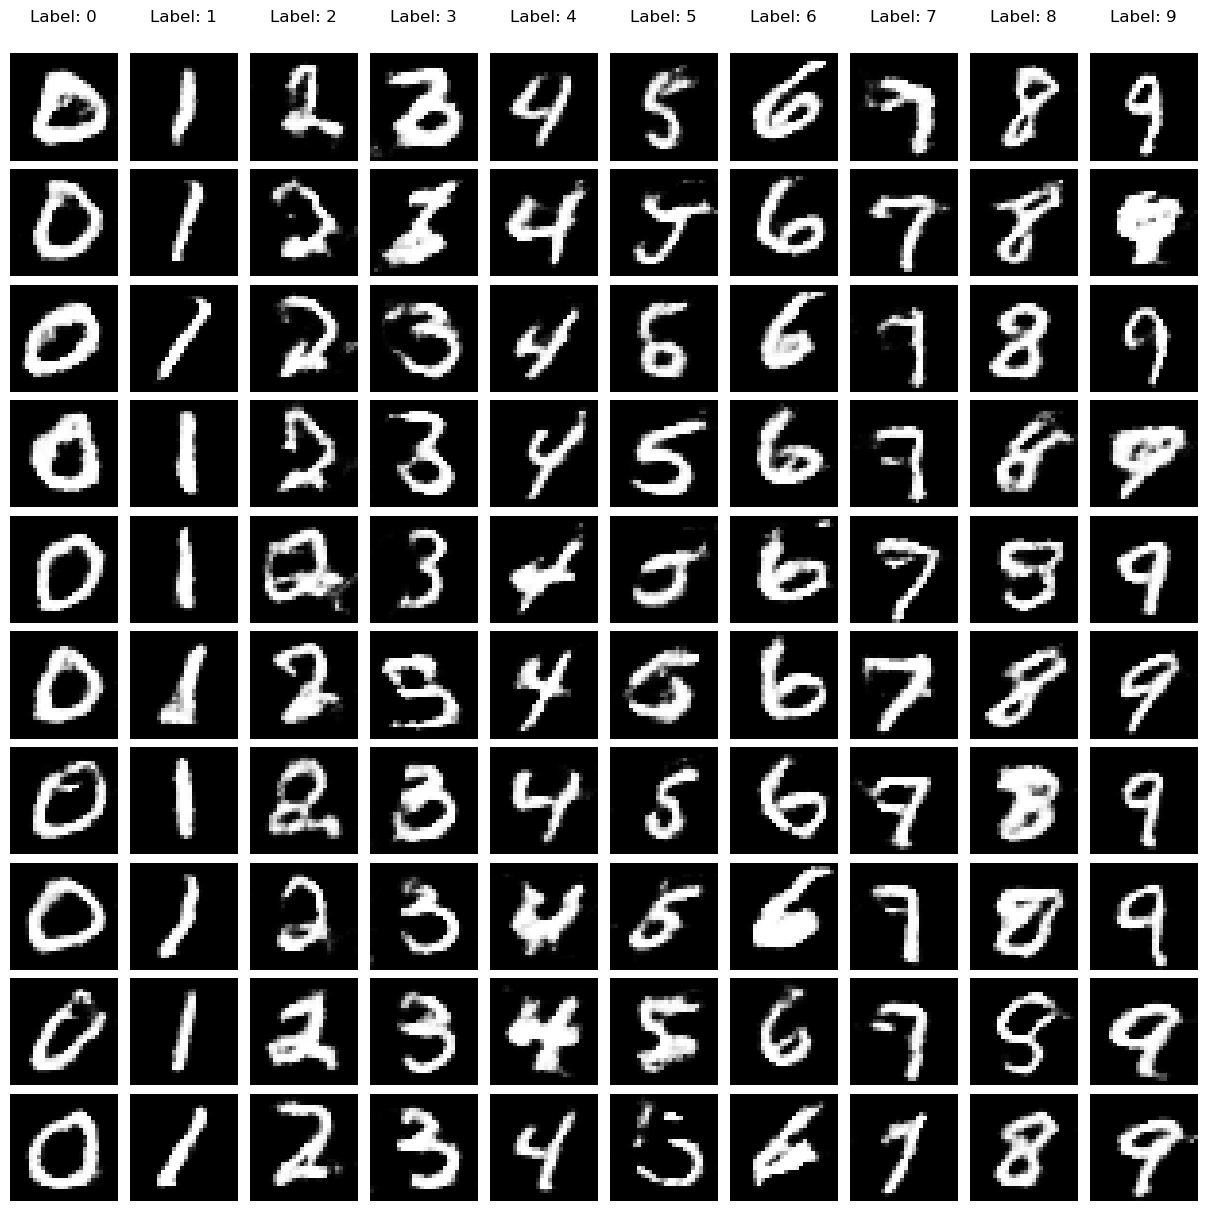

In [25]:
create_images()

The results of the Conditional GAN look very promising, even if there are of course a few bad pictures now and then. A CGAN is especially handy when you have conditions that are important for generating the data. For example, it makes it possible to generate data for classes that are generally poorly represented in the data.  The result of the CGAN could be better if we tuned the hyperparameters, but since we still wanted to implement the waterstone GAN, we did not have enough time. Still, we didn't want to give up the CGAN because it can be a particularly powerful and versatile model.